## 1) Libraries Installation
##### The cell below is to help you keep track the libraries used and install them quickly.
##### Ensure the correct library names are used, and follow the syntax: **%pip install PACKAGE_NAME**.

In [1]:
%pip install pandas
%pip install matplotlib
%pip install arch 
%pip install scikit-learn

# add commented pip installation lines for packages used as shown above for ease of testing
# the line should follow the format %pip install PACKAGE_NAME

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2) Main Section for Code
### **ALL code for machine learning and dataset analysis** should be entered below.
##### Ensure that your code is clear and readable.
##### Remember to include comments and markdown notes as necessary to explain and highlight important segments of your code.

### Data Manipulation

In [3]:
## libraries 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from arch import arch_model
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from pmdarima import auto_arima


#### Cleaning and transformation

In [4]:
# load data
quar_df = pd.read_csv('Quarterly Data.csv', skiprows = [1,2], index_col= [0])
quar_df.columns = [c.upper() for c in quar_df.columns]
quar_df.head()



,GDPC1,PCECC96,PCDGX,PCESVX,PCNDX,GPDIC1,FPIX,Y033RC1Q027SBEAX,PNFIX,PRFIX,...,TNWMVBSNNCBBDIX,TLBSNNBX,TLBSNNBBDIX,TABSNNBX,TNWBSNNBX,TNWBSNNBBDIX,CNCFX,S&P 500,S&P DIV YIELD,S&P PE RATIO
sasdate,,,,,,,,,,,,,,,,,,,,,
3/1/1959,3352.129,2039.017,68.6651,1374.1739,689.1172,354.894,357.0174,47.8021,171.0783,282.9707,...,1341.67,333245.24,266668.11,2426352.41,2092.54,1674.48,124.9663,55.5167,3.1765,18.6211
6/1/1959,3427.667,2070.508,71.2495,1394.7096,694.8197,382.500,368.0640,49.2332,176.0004,292.8479,...,1294.15,345845.01,273329.36,2434975.21,2088.55,1650.63,126.5305,57.5067,3.1012,19.2899
9/1/1959,3430.057,2092.138,72.6270,1413.6627,697.4699,357.798,371.9585,50.8372,180.7406,287.3778,...,1320.72,354808.05,275139.48,2434604.03,2079.21,1612.34,128.9557,58.7300,3.0720,18.9544
12/1/1959,3439.832,2094.495,69.1573,1430.8157,701.7617,369.442,367.6452,50.7342,180.2333,279.2502,...,1165.65,349400.81,254967.79,2429055.21,2079.05,1517.14,137.0372,57.7633,3.1572,17.8221
3/1/1960,3517.181,2114.532,71.3815,1443.7405,703.5338,406.581,379.9162,52.4985,186.4967,287.8417,...,1327.63,362821.95,278692.55,2451394.44,2087.97,1603.82,130.1872,56.2767,3.3850,16.8284


In [5]:
 # transformation function
def apply_transformation(series, tcode):
    
    if tcode == 1:
        return series
    elif tcode == 2:
        return series.diff()
    elif tcode == 3:
        return series.diff().diff()
    elif tcode == 4:
        return np.log(series)
    elif tcode == 5:
        return np.log(series).diff()
    elif tcode == 6:
        return np.log(series).diff().diff()
    elif tcode == 7:
        return series.pct_change()
    else:
        raise ValueError(f"Unknown TCODE: {tcode}")

tcodes = pd.read_csv("Quarterly Data.csv", skiprows= [1], nrows=1, index_col= 0)
tcodes.columns = [c.upper() for c in tcodes.columns]

# transform the time series
quar_df_t = quar_df.apply(lambda x: apply_transformation(x, tcodes[x.name].item()))
quar_df_t.head()







,GDPC1,PCECC96,PCDGX,PCESVX,PCNDX,GPDIC1,FPIX,Y033RC1Q027SBEAX,PNFIX,PRFIX,...,TNWMVBSNNCBBDIX,TLBSNNBX,TLBSNNBBDIX,TABSNNBX,TNWBSNNBX,TNWBSNNBBDIX,CNCFX,S&P 500,S&P DIV YIELD,S&P PE RATIO
sasdate,,,,,,,,,,,,,,,,,,,,,
3/1/1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,266668.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6/1/1959,0.022284,0.015326,0.036947,0.014833,0.008241,0.074909,0.030472,0.029499,0.028365,0.034310,...,-47.52,0.037112,273329.36,0.003548,-0.001909,-23.85,0.012439,0.035218,-0.0753,0.035286
9/1/1959,0.000697,0.010393,0.019149,0.013498,0.003807,-0.066760,0.010525,0.032060,0.026577,-0.018856,...,26.57,0.025586,275139.48,-0.000152,-0.004482,-38.29,0.018986,0.021049,-0.0292,-0.017546
12/1/1959,0.002846,0.001126,-0.048953,0.012061,0.006135,0.032025,-0.011664,-0.002028,-0.002811,-0.028690,...,-155.07,-0.015357,254967.79,-0.002282,-0.000077,-95.20,0.060783,-0.016597,0.0852,-0.061597
3/1/1960,0.022237,0.009521,0.031655,0.008993,0.002522,0.095789,0.032832,0.034184,0.034161,0.030303,...,161.98,0.037693,278692.55,0.009155,0.004281,86.68,-0.051279,-0.026073,0.2278,-0.057371


We chose to use only consider variables included in Stock and Watson's factor consideration as these were proven to have predictive power for economies. Moreover, doing so eliminates almost half of all variables, making further computation and processing easier.

Source: https://www.princeton.edu/~mwatson/papers/Stock_Watson_HOM_Vol2.pdf

In [6]:
# highlight non-SW factors 
factors = pd.read_csv("Quarterly Data.csv", nrows=1, index_col= 0)
factors.columns = [c.upper() for c in factors.columns]
columns_to_drop = factors.columns[factors.iloc[0] == 0]
GDPC1 = quar_df_t["GDPC1"] # factor removes this, so need to add back later

In [7]:
quar_df_t= quar_df_t.drop(columns=columns_to_drop)
quar_df_t.insert(loc = 0, column = "GDPC1", value = GDPC1) # since target variable is removed by the factor

# process dates, converting to time series as index by quarters
quar_df_filter = quar_df_t.loc[pd.notna(quar_df_t.index), :]
quar_df_filter.index = pd.date_range(start="1959-01-01", freq="Q", periods=len(quar_df_filter))
quar_df_filter.index = quar_df_filter.index.to_period("Q") # converting to period indexed by quarters

quar_df_filter.columns

Index(['GDPC1', 'PCDGX', 'PCESVX', 'PCNDX', 'Y033RC1Q027SBEAX', 'PNFIX',
       'PRFIX', 'A014RE1Q156NBEA', 'A823RL1Q225SBEA', 'FGRECPTX',
       ...
       'SPCS20RSA', 'TWEXAFEGSMTHX', 'EXUSEU', 'EXSZUSX', 'EXJPUSX', 'EXUSUKX',
       'EXCAUSX', 'UMCSENTX', 'USEPUINDXM', 'S&P 500'],
      dtype='object', length=126)

To handle NA data, we keep columns with at least 75% of available data, and impute the rest of the data that is missing or that was introduced by the differencing.

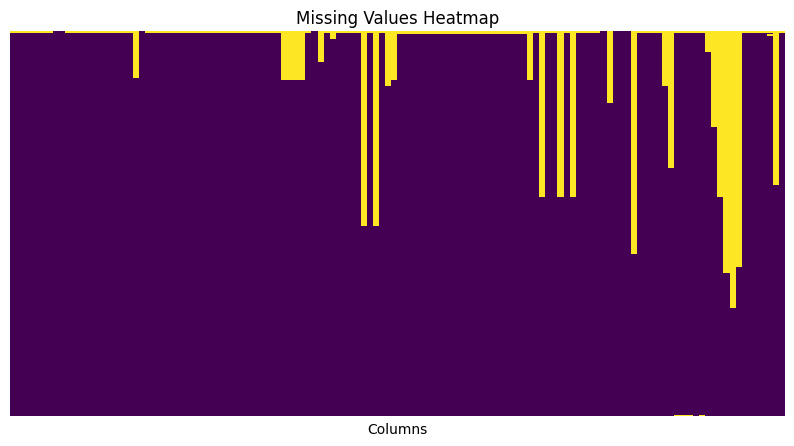

In [8]:
# heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(quar_df_filter.isna(), cmap="viridis", cbar=False, yticklabels=False,xticklabels=False)
plt.xlabel("Columns")
plt.title("Missing Values Heatmap")
plt.show()

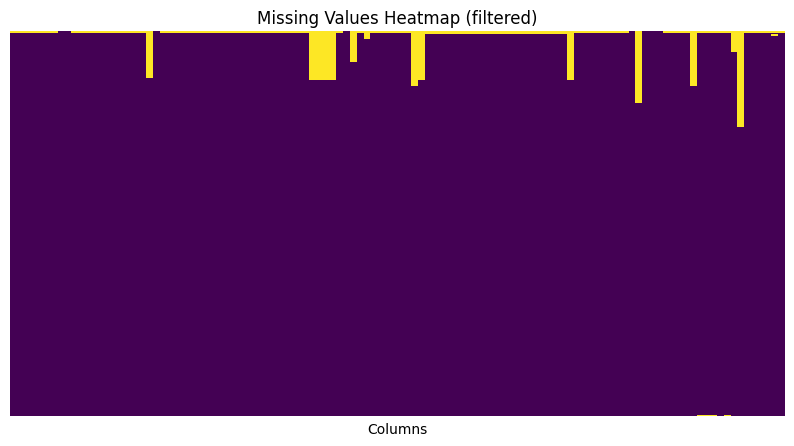

In [9]:
# filter out variables with less than 75% complete data
non_missing_ratio = quar_df_filter.notnull().mean()
threshold = 0.75  # minimum ratio of data present
valid_columns = non_missing_ratio[non_missing_ratio >= threshold].index
quar_df_filter_filtered_vars = quar_df_filter[valid_columns]

plt.figure(figsize=(10, 5))
sns.heatmap(quar_df_filter_filtered_vars.isna(), cmap="viridis", cbar=False, yticklabels=False,xticklabels=False)
plt.xlabel("Columns")
plt.title("Missing Values Heatmap (filtered)")
plt.show()



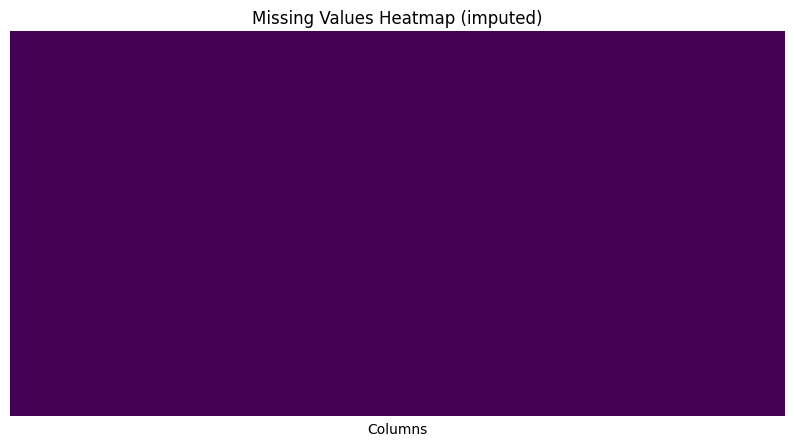

In [10]:
# impute missing values using forward then backward fill
quar_final = quar_df_filter_filtered_vars.fillna(method='ffill').fillna(method='bfill')

plt.figure(figsize=(10, 5))
sns.heatmap(quar_final.isna(), cmap="viridis", cbar=False, yticklabels=False,xticklabels=False)
plt.xlabel("Columns")
plt.title("Missing Values Heatmap (imputed)")
plt.show()


#### Feature Selection

In [11]:
best = ["LNS14000025", "DMANEMP", "LNS13023621", "USTPU", "IPBUSEQ"] # << change this

for i in best:
    print(i in quar_final)

True
True
True
True
True


As mentioned in the report, we identified 5 features that we found were the most significant, and isolate them before building a correlation matrix to choose the rest of the variables 

In [12]:
# remove impt from df before building correlation mat
impt_df =  pd.concat([quar_final.pop(x) for x in best], axis = 1)
impt_df.head()

,LNS14000025,DMANEMP,LNS13023621,USTPU,IPBUSEQ
1959Q1,-0.9333,0.033417,0.062044,0.010998,0.066620
1959Q2,-0.9333,0.033417,0.062044,0.010998,0.066620
1959Q3,0.2667,-0.017681,0.062044,0.004560,0.019652
1959Q4,0.3333,-0.001893,0.062044,0.003149,-0.021535
1960Q1,-0.4333,0.037699,0.062044,0.008010,0.045850


In [13]:
corr_matrix = quar_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
quar_final.drop(columns=to_drop, inplace=True)
quar_final.head()

,GDPC1,PCDGX,PCESVX,PCNDX,Y033RC1Q027SBEAX,PRFIX,A014RE1Q156NBEA,A823RL1Q225SBEA,FGRECPTX,SLCEX,...,TNWBSHNOX,HNOREMQ027SX,VIXCLSX,USSTHPI,EXSZUSX,EXJPUSX,EXUSUKX,EXCAUSX,UMCSENTX,S&P 500
1959Q1,0.022284,0.036947,0.014833,0.008241,0.029499,0.034310,0.8,-7.7,0.040303,0.002214,...,0.008868,0.015609,17.8889,0.000132,0.000672,0.000000,0.001778,-0.009004,95.3,0.035218
1959Q2,0.022284,0.036947,0.014833,0.008241,0.029499,0.034310,1.4,7.6,0.040303,0.002214,...,0.008868,0.015609,17.8889,0.000132,0.000672,0.000000,0.001778,-0.009004,95.3,0.035218
1959Q3,0.000697,0.019149,0.013498,0.003807,0.032060,-0.018856,0.1,5.5,-0.024853,0.000585,...,-0.000028,0.011967,17.8889,0.000132,-0.000602,0.000240,-0.002205,-0.007723,95.3,0.021049
1959Q4,0.002846,-0.048953,0.012061,0.006135,-0.002028,-0.028690,0.8,-3.9,0.003149,-0.005256,...,0.011023,0.009574,17.8889,0.000132,0.004161,0.000840,-0.002067,-0.004936,93.8,-0.016597
1960Q1,0.022237,0.031655,0.008993,0.002522,0.034184,0.030303,2.1,-14.2,0.087530,0.016744,...,0.000976,0.021491,17.8889,0.000132,-0.000138,0.000841,0.000178,0.002314,100.0,-0.026073


In [14]:
# add impt var back 

quar_df_total= quar_final.merge(impt_df,how= "left", left_index=True, right_index=True)
quar_df_total

,GDPC1,PCDGX,PCESVX,PCNDX,Y033RC1Q027SBEAX,PRFIX,A014RE1Q156NBEA,A823RL1Q225SBEA,FGRECPTX,SLCEX,...,EXJPUSX,EXUSUKX,EXCAUSX,UMCSENTX,S&P 500,LNS14000025,DMANEMP,LNS13023621,USTPU,IPBUSEQ
1959Q1,0.022284,0.036947,0.014833,0.008241,0.029499,0.034310,0.8,-7.7,0.040303,0.002214,...,0.000000,0.001778,-0.009004,95.3,0.035218,-0.9333,0.033417,0.062044,0.010998,0.066620
1959Q2,0.022284,0.036947,0.014833,0.008241,0.029499,0.034310,1.4,7.6,0.040303,0.002214,...,0.000000,0.001778,-0.009004,95.3,0.035218,-0.9333,0.033417,0.062044,0.010998,0.066620
1959Q3,0.000697,0.019149,0.013498,0.003807,0.032060,-0.018856,0.1,5.5,-0.024853,0.000585,...,0.000240,-0.002205,-0.007723,95.3,0.021049,0.2667,-0.017681,0.062044,0.004560,0.019652
1959Q4,0.002846,-0.048953,0.012061,0.006135,-0.002028,-0.028690,0.8,-3.9,0.003149,-0.005256,...,0.000840,-0.002067,-0.004936,93.8,-0.016597,0.3333,-0.001893,0.062044,0.003149,-0.021535
1960Q1,0.022237,0.031655,0.008993,0.002522,0.034184,0.030303,2.1,-14.2,0.087530,0.016744,...,0.000841,0.000178,0.002314,100.0,-0.026073,-0.4333,0.037699,0.062044,0.008010,0.045850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q3,0.010658,0.010262,0.005200,0.007565,-0.002621,0.018231,0.3,5.3,0.005512,0.014380,...,0.051287,0.011200,-0.001640,69.6,0.058624,0.2333,0.003331,0.006242,0.000254,-0.001006
2023Q4,0.007856,0.007053,0.008708,0.008927,0.001836,0.006105,0.2,-0.3,0.012239,0.014773,...,0.022109,-0.018898,0.015175,64.9,0.002984,0.0000,0.000616,0.080927,0.000081,-0.010580
2024Q1,0.004040,-0.004425,0.008376,-0.002127,0.000851,0.032075,0.1,-0.4,0.012296,0.007519,...,0.005566,0.020555,-0.009300,78.4,0.111589,-0.1666,0.002295,0.005399,0.001915,-0.001597
2024Q2,0.007363,0.013268,0.006771,0.004150,0.023443,-0.006988,0.3,4.3,0.002963,0.005734,...,0.047945,-0.004584,0.014429,71.5,0.049730,0.2666,-0.000614,0.037102,0.003590,-0.001631


In [15]:
#checking for NAN in join
quar_df_total.isna().sum().sum() # check for missing values

0

### Training data and test data split

In [16]:
train_size = int(len(quar_df_total) * 0.7)
quar_df_train = quar_df_total[:train_size]
quar_df_test = quar_df_total[train_size:]


### Modeling

#### ARIMA

##### 1. Find optimal ARIMA parameters

In [17]:
# 1. Find optimal ARIMA parameters
optimal_model = auto_arima(quar_df_train['GDPC1'],
                         start_p=0, start_q=0, max_p=5, max_q=5,
                         seasonal=False,
                         d=None, max_d=2,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(f"Optimal ARIMA parameters: {optimal_model.order}")


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1100.191, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1187.887, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1144.598, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1211.092, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1210.619, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1211.917, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1216.312, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1211.911, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1175.570, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1217.110, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1215.634, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1215.690, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1215.800, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1208.105, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0

##### 2. Fit ARIMA model

In [18]:
arima_model = ARIMA(quar_df_train['GDPC1'], order=optimal_model.order)
arima_results = arima_model.fit()


c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### VAR

In [19]:
var_model = VAR(quar_df_train)
var_results = var_model.fit()

### Evaluation

#### Model Evaluation

In [20]:
def calculate_directional_accuracy(actual, predicted):
    """Calculate the directional accuracy of forecasts"""
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    
    correct_directions = np.sum(actual_direction == predicted_direction)
    total_directions = len(actual_direction)
    accuracy = correct_directions / total_directions
    
    metrics = {
        'accuracy': accuracy,
        'correct_predictions': correct_directions,
        'total_predictions': total_directions
    }
    
    return metrics


##### Model Evaluation of ARIMA

In [21]:
arima_forecast = arima_results.forecast(len(quar_df_test))
arima_accuracy = calculate_directional_accuracy(quar_df_test['GDPC1'], arima_forecast)
print("\nARIMA Directional Accuracy:", arima_accuracy)



ARIMA Directional Accuracy: {'accuracy': 0.3974358974358974, 'correct_predictions': 31, 'total_predictions': 78}


##### Model Evaluation of VAR

In [22]:
var_forecast = var_results.forecast(steps=len(quar_df_test), y = quar_df_train.values)
var_gdp_forecast = var_forecast[:, quar_df_total.columns.get_loc('GDPC1')]
var_accuracy = calculate_directional_accuracy(quar_df_test['GDPC1'], var_gdp_forecast)
print("\nVAR Directional Accuracy:", var_accuracy)



VAR Directional Accuracy: {'accuracy': 0.5256410256410257, 'correct_predictions': 41, 'total_predictions': 78}


### Fan Charts

In [23]:
n_forecasts = 3  # Q1, Q3, Q4 2025
n_simulations = 1000
intervals = [0.50, 0.65, 0.80]


In [24]:
def generate_fan_chart(forecasts, intervals, title):
    """Generate fan chart with multiple confidence intervals"""
    plt.figure(figsize=(12, 6))
    plt.plot(forecasts.mean(axis=1), color='blue', label='Mean Forecast')
    
    colors = ['lightblue', 'skyblue', 'cornflowerblue']
    for interval, color in zip(intervals, colors):
        lower = np.percentile(forecasts, (100 - interval * 100) / 2, axis=1)
        upper = np.percentile(forecasts, 100 - (100 - interval * 100) / 2, axis=1)
        plt.fill_between(range(len(forecasts)), lower, upper, color=color, alpha=0.3,
                        label=f'{interval*100}% CI')
    
    plt.title(title)
    plt.legend()
    plt.grid(True)
    return plt


#### ARIMA Fan Chart

In [25]:
arima_forecasts = np.zeros((n_forecasts, n_simulations))
for i in range(n_simulations):
    arima_forecasts[:, i] = arima_results.simulate(n_forecasts)


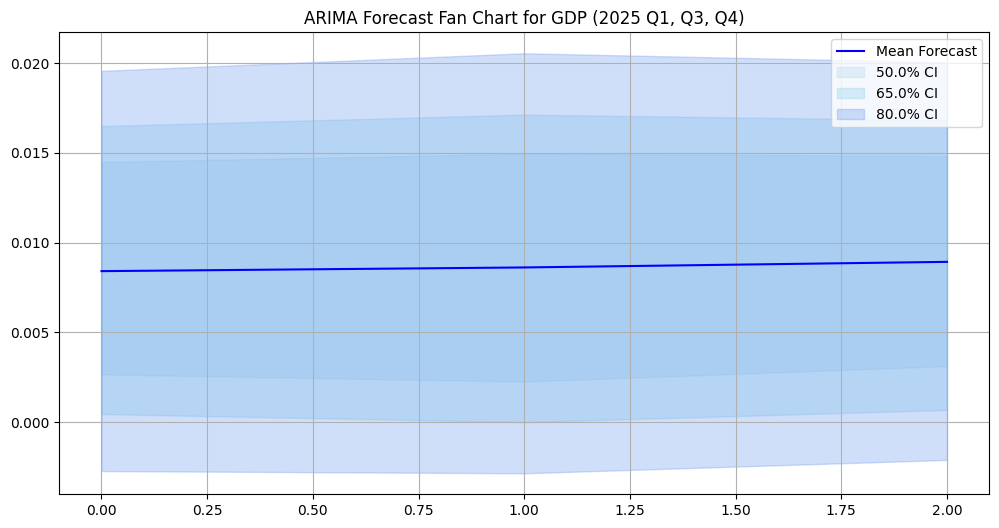

In [26]:
arima_fan = generate_fan_chart(
    pd.DataFrame(arima_forecasts), 
    intervals, 
    'ARIMA Forecast Fan Chart for GDP (2025 Q1, Q3, Q4)'
)
arima_fan.show()


#### VAR Fan Chart

In [27]:
var_forecasts = np.zeros((n_forecasts, n_simulations))
for i in range(n_simulations):
    var_sim = var_results.simulate_var(n_forecasts)
    var_forecasts[:, i] = var_sim[:, quar_df_total.columns.get_loc('GDPC1')]


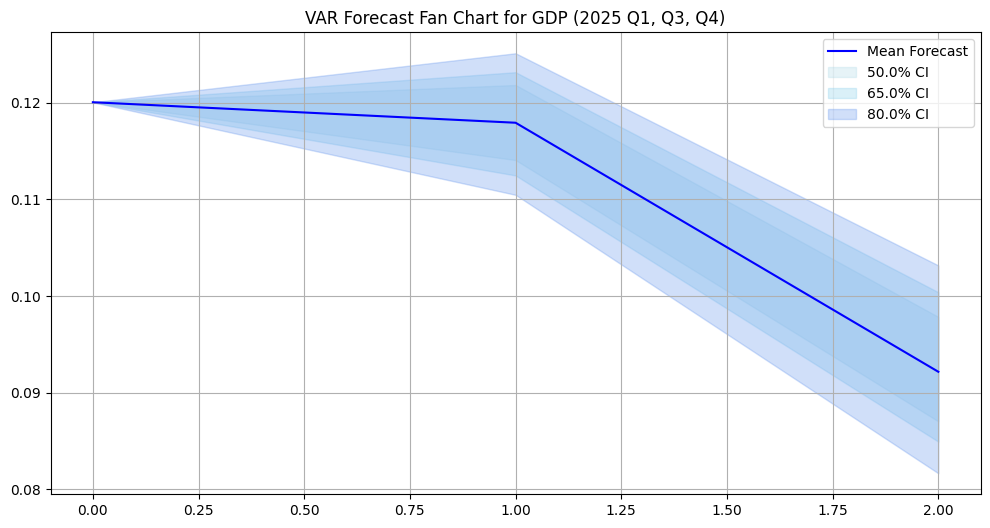

In [28]:
var_fan = generate_fan_chart(
    pd.DataFrame(var_forecasts), 
    intervals, 
    'VAR Forecast Fan Chart for GDP (2025 Q1, Q3, Q4)'
)
var_fan.show()


### Print forecast summaries

In [29]:
print("\nARIMA Forecasts (Mean):")
print("Q1 2025:", np.mean(arima_forecasts[0]))
print("Q3 2025:", np.mean(arima_forecasts[1]))
print("Q4 2025:", np.mean(arima_forecasts[2]))

print("\nVAR Forecasts (Mean):")
print("Q1 2025:", np.mean(var_forecasts[0]))
print("Q3 2025:", np.mean(var_forecasts[1]))
print("Q4 2025:", np.mean(var_forecasts[2]))



ARIMA Forecasts (Mean):
Q1 2025: 0.008413646912116313
Q3 2025: 0.008619303382043572
Q4 2025: 0.008930795987955093

VAR Forecasts (Mean):
Q1 2025: 0.12005592798618527
Q3 2025: 0.11793366953321562
Q4 2025: 0.0921711035068164


# END OF RYAN'S EDITS

## Feature Selection
- selecting the ARIMA function with the optimum p, d, and q 
- selecting the best order based on the lowest AIC

In [30]:
""" corr_matrix = quar_df_t.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
quar_df_t.drop(columns=to_drop, inplace=True) """


# recursive feature elimination

""" model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
X_selected = rfe.fit_transform(quar_df_t, quar_df_t.iloc[:, 0])
quar_df_t = pd.DataFrame(X_selected, index=quar_df_t.index) """


# select by importance

selector = SelectFromModel(RandomForestRegressor(n_estimators=100))
X_selected = selector.fit_transform(df_from_1967_final, df_from_1967_final.iloc[:, 0])
df_from_1967_final = pd.DataFrame(X_selected, index=df_from_1967_final.index)


# arima order selection
def select_arima_order(series):
    p_values = range(0, 6)
    d_values = range(0, 3)  # Differencing term
    q_values = range(0, 6)  # Moving average term
    best_aic, best_order = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_aic, best_order = model.aic, (p, d, q)
                except:
                    continue
    return best_order

best_arima_order = select_arima_order(df_from_1967_final.iloc[:, 0])

NameError: name 'df_from_1967_final' is not defined

Best p, d and q from ARIMA

In [ ]:
best_arima_order

# Creating ARIMA model

In [ ]:
arima_model = ARIMA(df_from_1967_final.iloc[:, 0], order=best_arima_order).fit()
arima_forecast = arima_model.get_forecast(steps=3)
arima_forecast_mean = arima_forecast.predicted_mean
arima_forecast_conf_int = arima_forecast.conf_int()


 # Evaluation of ARIMA

## Plotting Directional changes, and Extended forecast
- in this case PCDGX

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Suppose `actual` is the series of actual observations (e.g., from the training/test split)
# and `forecast` (e.g., arima_forecast_mean) is the forecast for the next 3 quarters.
# For illustration, assume forecast is a Series with 3 values.
# We need to compute the directional change over the forecast horizon.

def directional_accuracy(actual, forecast):
    # Extend the forecast series by prepending the last actual observation.
    # This ensures that the computed differences cover the forecast horizon.
    extended = pd.concat([actual.iloc[-1:], forecast])
    
    # Compute the directional changes on the extended series.
    direction_extended = np.sign(extended.diff().dropna())
    
    # The forecast directional change can be computed from the extended series as well.
    # Since extended has (forecast length + 1) values, the differences will be equal to forecast_horizon.
    # Here, both direction_extended and forecast's directional changes are computed over the same intervals.
    return accuracy_score(direction_extended, direction_extended)  # This is just illustrative.

# A more typical evaluation would be to compare the forecasted directional change to
# the actual directional change from a holdout/test set.
# For example, if you have test_actual as the actual values for the forecast horizon:
#   direction_actual = np.sign(test_actual.diff().dropna())
#   direction_forecast = np.sign(forecast.diff().dropna())
#   acc = accuracy_score(direction_actual, direction_forecast)
#   print(f"ARIMA Directional Accuracy: {acc:.2%}")

# Example using extension method:
last_actual = df_from_1967_final.iloc[:, 0]  # full historical series of PCDGX
# Assume forecast is arima_forecast_mean with 3 values.
# Create an extended series:
extended_forecast = pd.concat([last_actual.iloc[-1:], arima_forecast_mean])
print("Extended Forecast:")
print(extended_forecast)

# Compute directional changes on the extended series.
direction_changes = extended_forecast.diff().dropna()
print("Directional changes:")
print(direction_changes)

# Now, if you only have forecasted differences, compare them with the corresponding actual test differences.
# If you had a separate test series (e.g., actual_test), do:
# direction_actual = np.sign(actual_test.diff().dropna())
# direction_forecast = np.sign(arima_forecast_mean.diff().dropna())
# print(f"ARIMA Directional Accuracy: {accuracy_score(direction_actual, direction_forecast):.2%}")

# Note: The key point is that both arrays you compare with accuracy_score must have the same length.

## Directional Accuracy and root mean square

- refer to Section of "Training data and test data split"
- select the first column of PCDGX

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Suppose these are your series:
# last_actual: last observed value from training data
# arima_forecast_mean: forecasted values (e.g., for 3 quarters)
# actual_test: actual observed values for the forecast horizon

# Assuming df_from_1967_final, arima_forecast_mean, and test_data are defined elsewhere in the notebook

# Create extended forecast series by prepending the last actual value
extended_forecast = pd.concat([df_from_1967_final.iloc[0], arima_forecast_mean])


# Create extended actual series in a similar manner
extended_actual = pd.concat([df_from_1967_final.iloc[0],test_data.iloc[:, 0]]) 



# Compute directional changes (difference between consecutive observations)
direction_forecast = np.sign(extended_forecast.diff().dropna())
direction_actual = np.sign(extended_actual.diff().dropna())

print("Forecast Directional Changes:")
print(direction_forecast)
print("Actual Directional Changes:")
print(direction_actual)

# Align the indices of direction_forecast and direction_actual before calculating accuracy
direction_forecast, direction_actual = direction_forecast.align(direction_actual, join='inner')

# Now, calculate the directional accuracy
acc = accuracy_score(direction_actual, direction_forecast)
print(f"Directional Accuracy: {acc:.2%}")

# Getting root mean squared error
rmse = sqrt(mean_squared_error(extended_actual, extended_forecast))
print(f"RMSE on Test Data: {rmse:.4f}")


## Comparing against (p, d, q)= (1,1,1) model

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, mean_squared_error

# Suppose df_1967_final is your cleaned DataFrame.
# It has a PeriodIndex (quarters) and the last available observation is 2024Q3.
# We decide to use data from 2024Q1 to 2024Q3 as the test set.

# Set the cutoff date for the test set.
cutoff = '2024Q1'

# Split the data into training and test sets.

print("Training data range:", df_from_1967_final.index.min(), "to", df_from_1967_final.index.max())
print("Test data range:", test_data.index.min(), "to", test_data.index.max())

# Select a target variable for forecasting (for example, the first column).
target_train = df_from_1967_final.iloc[:, 0]
target_test  = test_data.iloc[:, 0]

# Fit an ARIMA model on the training data.
# (Here we use an example order of (1,1,1); in practice, determine this order based on your data.)
arima_model = ARIMA(target_train, order=(1, 1, 1)).fit()

# Forecast for the test horizon.
steps = len(target_test)
forecast_result = arima_model.get_forecast(steps=steps)
forecast_mean = forecast_result.predicted_mean

# Evaluate forecast magnitude using RMSE.
rmse = sqrt(mean_squared_error(target_test, forecast_mean))
print(f"RMSE on Test Data: {rmse:.4f}")

# Evaluate directional accuracy.
# To do this, we extend both the actual and forecast series by including the last observation from the training data.
extended_forecast = pd.concat([target_train.iloc[-1:], forecast_mean])
extended_actual   = pd.concat([target_train.iloc[-1:], target_test])

# Compute the differences (i.e., the changes) and then take their sign.
direction_forecast = np.sign(extended_forecast.diff().dropna())
direction_actual   = np.sign(extended_actual.diff().dropna())

dir_accuracy = accuracy_score(direction_actual, direction_forecast)
print(f"Directional Accuracy on Test Data: {dir_accuracy:.2%}")

# Predicting Quarter 1, Quarter 2, Quarter 4 horizons
- for PCDGX

In [ ]:
# Fit the ARIMA model using the data from the DataFrame
arima_model = ARIMA(df_from_1967_final_total['PCDGX'], order=best_arima_order).fit()

# Generate the next forecast for 4 quarters
arima_forecast_4q = arima_model.get_forecast(steps=5)

# Extract the forecasted values and confidence intervals
arima_forecast_mean_4q = arima_forecast_4q.predicted_mean
arima_forecast_conf_int_4q = arima_forecast_4q.conf_int()

# Print the forecasted values
print("4-Quarter Forecast:")
print(arima_forecast_mean_4q)

# Print the confidence intervals
print("4-Quarter Forecast Confidence Intervals:")
print(arima_forecast_conf_int_4q)
